In [1]:
import matplotlib.pyplot as plt
import statsbombpy
import itertools
from statsbombpy import sb
from mplsoccer import VerticalPitch, FontManager
from mplsoccer.statsbomb import read_event, read_lineup, EVENT_SLUG, LINEUP_SLUG
import pandas as pd
import json
import numpy as np
from vector_angle import *
%load_ext autotime

plt.style.use('seaborn-white')


# Declaring credentials
credentials={'user':'vignesh.jayanth@staderennais.fr','passwd':'7XtHANc7'}

time: 440 µs (started: 2021-10-04 09:36:56 +02:00)


In [64]:
print(plt.style.available)

# Enter Team of Player here #
Team=['Montpellier','Rennes']


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
time: 22.5 ms (started: 2021-10-04 15:48:58 +02:00)


In [3]:
filename1 = '/Users/vignesh.jayanth/Documents/Trial-Data Exports 2021/France_Ligue_1_2021_2022.h5'
filename2 = '/Users/vignesh.jayanth/Documents/Trial-Data Exports 2021/France_Ligue_1_2020_2021.h5'

key='df'
df_20_21=pd.read_hdf(filename1,key)
df_21_22=pd.read_hdf(filename2,key)


df=df_20_21.append(df_21_22)
df=pd.concat([df_20_21, df_21_22])

time: 2min 14s (started: 2021-10-04 09:37:02 +02:00)


In [4]:
df=df.sort_values(by=['match_id','index'], ascending=False).reset_index(drop=True)

time: 38.4 s (started: 2021-10-04 09:39:16 +02:00)


In [5]:
# Splitting the 50_50 column #

df['50_50'] = df['50_50'].fillna({i: {} for i in df.index})  # if the column is not strings
df = df.join(pd.json_normalize(df['50_50']))

# drop 50_50
df.drop(columns=['50_50'], inplace=True)

time: 42.7 s (started: 2021-10-04 09:39:54 +02:00)


In [6]:
# Splitting the location column into different Start x, Start y and Start Z columns
df['location'] = df['location'].fillna({i: [] for i in df.index})  # if the column is not strings
df[['Start_x','Start_y','Start_z']] = pd.DataFrame(df['location'].tolist(), index= df.index).fillna(0)

# Splitting the location column into different End x, End y and End Z columns
# Fill rows as nan if they aren't of type dict to keep it coherent

df['pass_end_location'] = df['pass_end_location'].fillna({i: [] for i in df.index})  # if the column is not strings
df['goalkeeper_end_location'] = df['goalkeeper_end_location'].fillna({i: [] for i in df.index})  # if the column is not strings
df['carry_end_location'] = df['carry_end_location'].fillna({i: [] for i in df.index})  # if the column is not strings
df['shot_end_location'] = df['shot_end_location'].fillna({i: [] for i in df.index})  # if the column is not strings

# Split the location rows in a list to dataframe #
df[['goalkeeper_end_x','goalkeeper_end_y']] = pd.DataFrame(df['goalkeeper_end_location'].tolist(), index= df.index).fillna('')
df[['pass_end_x','pass_end_y']] = pd.DataFrame(df['pass_end_location'].tolist(), index= df.index).fillna('')
df[['carry_end_x','carry_end_y']] = pd.DataFrame(df['carry_end_location'].tolist(), index= df.index).fillna('')
df[['shot_end_x','shot_end_y','End_z']] = pd.DataFrame(df['shot_end_location'].tolist(), index= df.index).fillna('')

# Combine the necessary columns into one for uniformity #
df['End_x'] = df[['goalkeeper_end_x','pass_end_x',
                           'carry_end_x','shot_end_x']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df['End_y'] = df[['goalkeeper_end_y','pass_end_y',
                           'carry_end_y','shot_end_y']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

# Drop unnecessary columns #
df=df.drop(['goalkeeper_end_x','pass_end_x','carry_end_x','shot_end_x','goalkeeper_end_y','pass_end_y',
          'carry_end_y','shot_end_y','location','carry_end_location','goalkeeper_end_location',
          'shot_end_location','pass_end_location'], axis=1)

# Replace Blanks with np.nan's #
df['End_x']=df['End_x'].replace('', np.nan).fillna(0)
df['End_y']=df['End_y'].replace('', np.nan).fillna(0)
df['End_x']=df['End_x'].astype(float)
df['End_y']=df['End_y'].astype(float)
df['End_y']=np.where(df['End_y']==0,df['Start_y'],df['End_y'])
df['End_x']=np.where(df['End_x']==0,df['Start_x'],df['End_x'])

df=df.rename(columns={'End_x': 'End_x_sb', 'End_y': 'End_y_sb',
                      'Start_x': 'Start_x_sb', 'Start_y': 'Start_y_sb','Start_z': 'Start_z_sb'})


def convert_dim(df):
    df['Start_x']=df['Start_x_sb']*0.868
    df['End_x']=df['End_x_sb']*0.868
    df['Start_y']=df['Start_y_sb']*0.84
    df['End_y']=df['End_y_sb']*0.84
    
    return df

df3=convert_dim(df)


time: 2min 14s (started: 2021-10-04 09:40:37 +02:00)


In [7]:
df4=df3.copy()

time: 3.83 s (started: 2021-10-04 09:42:52 +02:00)


In [8]:
c = df3.filter(regex='switch')
print(list(c.columns))


['pass_switch']
time: 281 ms (started: 2021-10-04 09:42:56 +02:00)


In [9]:
# Get all the ids of the shots
# Check for HNL League
Comps=pd.DataFrame(sb.competitions(fmt="dict",creds=credentials)).T.reset_index(drop=True)
seasons=['2021/2022','2020/2021']
Comps1=Comps[(Comps['season_name'].isin(seasons)) & 
            (Comps['competition_name']=='Ligue 1') &
            (Comps['country_name']=='France')].reset_index(drop=True)

combo1=[]

for i in range(len(Comps1)):
    A=sb.matches(competition_id=Comps1.competition_id[i], season_id=Comps1.season_id[i],creds=credentials)
    all_matches=A[['match_id','match_date','season','match_week','competition','home_team','away_team']]
    
    combo1.append(all_matches)

all_matches_final=pd.concat(combo1)
## event data
Player='Gaëtan Laborde'

AOP=df3[(df3.type=='Shot') & (df3['player']==Player)].sort_values(by=['match_id','timestamp'], ascending=False)

AOP1 = AOP.reset_index()
AOP1=AOP1[['level_0','possession_team']].reset_index()
AOP1['level_2']=AOP1['level_0']-1
AOP1['level_1']=AOP1['level_0']+10

B=[]

for i in range(len(AOP1)):
    id_list=list(range(AOP1['level_2'][i],AOP1['level_1'][i]))
    B.append(id_list)
    
ind_list = list(itertools.chain(*B))

prev_actions=['Pass','Dribble', 'Carry','Shot']

AOP=df3.iloc[ind_list][['team','pass_technique','pass_cross','pass_shot_assist','timestamp','pass_switch',
                        'Start_z_sb','pass_deflected','Start_x','Start_y','shot_outcome','pass_cut_back',
                        'type','match_id','position','pass_goal_assist','pass_height',
                        'End_x', 'End_y','End_z',]]

AOP['level_0']=AOP.index

AOP=pd.merge(AOP,all_matches_final,on='match_id',how='left')
AOP['Opposition']=np.where(AOP['home_team']!=AOP['team'],AOP['home_team'],AOP['away_team'])

AOP=AOP[AOP['type'].isin(prev_actions)]

AOP=pd.merge(AOP,AOP1[['level_0','index','possession_team']],on='level_0',how='left')

AOP['index']=AOP['index'].fillna(method='ffill')
AOP['possession_team']=AOP['possession_team'].fillna(method='ffill')

AOP['Chain_count'] = AOP.groupby((AOP['index'] != AOP['index'].shift(1)).cumsum()).cumcount()+1

AOP=AOP.sort_values(by=['index','timestamp'], ascending=True).reset_index(drop=True)
AOP['index']=AOP['index'].astype(int)

AOP.drop(columns=['away_team','home_team','match_week','level_0','season'], inplace=True)

AOP['pass_cross']=np.where(AOP['pass_cross']==True,'Cross',AOP['pass_cross'])
AOP['pass_cut_back']=np.where(AOP['pass_cut_back']==True,'Cut Back',AOP['pass_cut_back'])
AOP['pass_switch']=np.where(AOP['pass_switch']==True,'Switch',AOP['pass_switch'])

# Keep Chain_count == 2 and team = Possession Team#
#prev_action=AOP[AOP['possession_team']==AOP['team']].reset_index(drop=True)

prev_action=AOP[AOP['Chain_count']==2].reset_index(drop=True)

prev_action['pass_cross'] = prev_action['pass_cross'].fillna(prev_action['pass_technique']).fillna(prev_action['pass_cut_back'])
prev_action['pass_cross']=prev_action['pass_cross'].fillna('')

corner_passes=['Straight', 'Inswinging', 'Outswinging']

prev_action['type']=np.where(prev_action['pass_technique'].isin(corner_passes),'Corner Pass',prev_action['type'])

prev_action['Pass_Type']=prev_action['pass_cross']+' '+prev_action['type']
prev_action['Pass_Type']=prev_action['Pass_Type'].str.strip()

prev_action=prev_action[['Start_x','Start_y','End_x','End_z','End_y','match_date','Opposition',
                         'Pass_Type','possession_team','position','index']]

prev_action

Start_x  Start_y     End_x End_z   End_y  match_date     Opposition  \
0     87.6680   53.676   91.5740        33.348  2021-09-26       Bordeaux   
1     98.0840   61.992   98.1708        37.548  2021-09-26       Bordeaux   
2    101.9900   43.932  100.6880        33.852  2021-09-26       Bordeaux   
3     99.5596   19.572   99.3860        21.336  2021-08-29          Lille   
4     87.7548   38.304   92.4420        42.420  2021-09-22  Clermont Foot   
..        ...      ...       ...   ...     ...         ...            ...   
118  101.4692   55.440   95.8272        31.164  2020-09-12       OGC Nice   
119   88.4492    4.872   94.3516        30.576  2020-08-29         Rennes   
120   74.9952   54.936   92.7024        45.948  2020-08-29         Rennes   
121   69.7872    2.436   96.0008        28.896  2020-08-29         Rennes   
122   90.7060    5.628   94.6988        35.364  2020-09-15           Lyon   

      Pass_Type possession_team              position  index  
0    Cross Pass          Rennes  Left Center Midfield      0  
1    Cross Pass          Rennes   Left Center Forward      1  
2    Cross Pass          Rennes            Right Back      2  
3          Pass     Montpellier        Center Forward      3  
4         Carry          Rennes            Right Wing      4  
..          ...             ...                   ...    ...  
118  Cross Pass     Montpellier     Right Center Back    120  
119  Cross Pass     Montpellier             Left Back    121  
120       Carry          Rennes        Center Forward    122  
121        Pass     Montpellier  Left Center Midfield    123  
122  Cross Pass     Montpellier        Left Wing Back    124  

[123 rows x 11 columns]

time: 2.77 s (started: 2021-10-04 09:42:56 +02:00)


In [245]:

check=prev_action[prev_action['pass_technique']=='Straight'][['pass_technique','pass_cross','pass_height']]
check

pass_technique pass_cross pass_height
5       Straight   Straight   High Pass

time: 6.24 ms (started: 2021-10-01 18:09:59 +02:00)


In [57]:
# Check for HNL League
Comps=pd.DataFrame(sb.competitions(fmt="dict",creds=credentials)).T.reset_index(drop=True)
seasons=['2021/2022','2020/2021']
Comps1=Comps[(Comps['season_name'].isin(seasons)) & 
            (Comps['competition_name']=='Ligue 1') &
            (Comps['country_name']=='France')].reset_index(drop=True)

combo1=[]

for i in range(len(Comps1)):
    A=sb.matches(competition_id=Comps1.competition_id[i], season_id=Comps1.season_id[i],creds=credentials)
    all_matches=A[['match_id','match_date','season','match_week','competition','home_team','away_team']]
    
    combo1.append(all_matches)

all_matches_final=pd.concat(combo1)

## event data
Player='Gaëtan Laborde'


Sub=df3[(df3.type=='Shot') & (df3['player']==Player)].sort_values(by=['match_id','timestamp'], ascending=False)

Sub = Sub.reset_index()
Sub=pd.merge(Sub,all_matches_final,on='match_id',how='left')

Sub=Sub.rename(columns={'player': 'Shooter'})


D=[]

for index, row in Sub.iterrows():
    
    A=str(row['shot_freeze_frame'])
    A=A.replace("'", '"')
    B=A.replace("True", 'true')
    B=B.replace("False", 'false')
    
    try:
        C=json.loads(B)
        for i in C:
            i["index"]=index
    except:
        continue
    D.extend(C)    

df2 = pd.concat([pd.DataFrame(D)])


df2['location'] = df2['location'].fillna({i: [] for i in df2.index})  # if the column is not strings
df2[['x','y']] = pd.DataFrame(df2['location'].tolist(), index= df2.index).fillna(0)
df2 = df2.join(pd.json_normalize(df2['player']))
df2=df2.rename(columns={'id': 'player_id', 'name': 'player_name'})

df2 = df2.join(pd.json_normalize(df2['position']))
df2=df2.rename(columns={'id': 'position_id', 'name': 'position_name'})


# drop 50_50
df2.drop(columns=['player'], inplace=True)
df2.drop(columns=['position'], inplace=True)
df2.drop(columns=['location'], inplace=True)
df2=df2.rename(columns={'player_name': 'player'})

def convert_dim(df):
    df['x']=df['x']*0.868
    df['y']=df['y']*0.84
    
    return df

df2_1=convert_dim(df2)


LM=pd.merge(df2_1,Sub[['shot_statsbomb_xg','Shooter','Start_x','Start_y','Start_z_sb','minute',
                       'play_pattern','shot_type','shot_outcome','shot_technique','under_pressure','second',
                       'shot_body_part','duration','team','match_date','home_team','away_team',
                    'shot_first_time','End_x','End_y','End_z']], right_on=Sub.index,left_on='index',how='left')

Positions = {'Left Center Forward':'LCF','Right Wing Back':'RWB',
'Center Defensive Midfield':'CDM','Right Center Forward':'RCF',
'Right Attacking Midfield':'RAM','Right Center Back':'RCB',
'Left Wing Back':'LWB','Left Center Midfield':'LCM',
'Center Attacking Midfield':'CAM','Left Midfield':'LM',
'Goalkeeper':'GK','Right Defensive Midfield':'RDM','Center Back':'CB',
'Left Defensive Midfield':'LDM','Right Midfield':'RM',
'Right Back':'RB','Right Wing':'RW','Center Forward':'CF','Left Attacking Midfield':'LAM',
'Substitute':'SUB','Left Center Back':'LCB','Right Center Midfield':'RCM','Left Wing':'LW','Left Back':'LB'}

LM['Abb_Positions'] = LM['position_name'].map(Positions)

LM['Team']=np.where(LM.teammate==False,'Opposition',LM['team'])
LM['Opposition']=np.where(LM['home_team']!=LM['team'],LM['home_team'],LM['away_team'])

LM['Goal_mid_x']=105
LM['Goal_mid_y']=34

LM['Goal_top_x']=105
LM['Goal_top_y']=30

LM['Goal_botm_x']=105
LM['Goal_botm_y']=38

def add_shot_distance_to_ball(df3):

    df3['Shot_distance'] = df3[['Start_x', 'Start_y']].sub(np.array(df3[['Goal_mid_x', 'Goal_mid_y']] )).pow(2).sum(1).pow(0.5)
    df3.distance = df3.Shot_distance.round(2)
    return(df3)

LM=add_shot_distance_to_ball(LM)

LM=LM.rename(columns={'key_0': 'index'})


time: 702 ms (started: 2021-10-04 10:36:03 +02:00)


In [58]:
def area(x1, y1, x2, y2, x3, y3):
    
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1)
                + x3 * (y1 - y2)) / 2.0)

LM['A']=area(LM.Start_x,LM.Start_y,LM.Goal_top_x,
                      LM.Goal_top_y,LM.Goal_botm_x,LM.Goal_botm_y)

LM['A1']=area(LM.x,LM.y,LM.Goal_top_x,
                      LM.Goal_top_y,LM.Goal_botm_x,LM.Goal_botm_y)

LM['A2']=area(LM.x,LM.y,LM.Start_x,LM.Start_y,LM.Goal_botm_x,LM.Goal_botm_y)

LM['A3']=area(LM.x,LM.y,LM.Start_x,LM.Start_y,LM.Goal_top_x,LM.Goal_top_y)

LM['A4']=LM['A1']+LM['A2']+LM['A3']
LM['A4']=LM['A4'].astype(int)
LM['A']=LM['A'].astype(int)
LM['A_final']=LM['A']-LM['A4']
areas=[-3,-2,-1,0,1,2,3]
LM['Players_in_play']=np.where(LM['A_final'].isin(areas),'Inside','Outside')

# Check the number of players behind/ahead of the shot #

Count=pd.DataFrame(LM.groupby(['Players_in_play','Team','index']).size()).set_axis(['Count of Players'], axis=1, inplace=False)
Count.reset_index(level=[0],inplace = True)
Count.reset_index(level=[0],inplace = True)
Count.reset_index(level=[0],inplace = True)
Count=Count[(Count['Players_in_play']=='Inside') & (Count['Team']=='Opposition')].reset_index(drop=True)
Count.drop(['Players_in_play','Team'], axis = 1, inplace=True)
Count = Count.rename(columns={'Count of Players': 'Opp_players_Front_of_Shot'})

LM=pd.merge(LM,Count,left_on='index',right_on='index',how='left')

LM['pressure_ind']=np.where(LM['under_pressure']==True,1,0)
LM['shot_first_time_ind']=np.where(LM['shot_first_time']==True,1,0)
LM['Shot_distance_ind']=np.where(LM['Start_x']>87,'Inside-Box','Outside-Box')
LM['Opp_players_Front_of_Shot']=LM['Opp_players_Front_of_Shot'].fillna(0).astype(int)
LM['Opp_players_Front_of_Shot']=LM['Opp_players_Front_of_Shot']-1

#Assigning Bins to Players
bins = [0,2,4,6]
labels = ["1-2","3-4","5-6"]
LM['Opp_players_Front_of_Shot1']= pd.cut(LM['Opp_players_Front_of_Shot'], bins=bins, labels=labels)

# Calculate speed of Shot
LM['Shot_Speed']= LM['Shot_distance']/LM['duration']

#Assigning Bins to Players
bins = [0,10,18,25,30,100]
labels = ["0-10 metres","11-18 metres","19-25 metres","26-30 metres","30+ metres"]
LM['Distance_of_Shot1']= pd.cut(LM['Shot_distance'], bins=bins, labels=labels)

LM = LM.rename(columns={'Start_z_sb': 'shot_start_height','End_z': 'shot_end_height'})

# Convert shot_end_height to int- fill na to 0
LM['shot_end_height']=LM['shot_end_height'].replace(r'^\s*$', np.nan, regex=True)
LM['shot_end_height']=LM['shot_end_height'].fillna(0)

# Calculate Angle of Shot
LM['Start_Coords'] = list(zip(LM.Start_x, LM.Start_y,LM.shot_start_height))
LM['End_Coords'] = list(zip(LM.End_x, LM.End_y,LM.shot_end_height))

A=[]

for i in range(len(LM)):
    
    Angle=angle_between(LM['Start_Coords'][i],LM['End_Coords'][i])
    A.append(Angle)
    
A1=pd.DataFrame(A).set_axis(['Angle_Of_Shot'], axis=1, inplace=False)
LM=pd.merge(LM,A1, left_index=True, right_index=True)


# Add indicator if the ball gone above bar or not
LM['Shot_height_Indicator']=np.where(LM['shot_end_height']>2.67,'Above Goal','On Goal')

LM=LM[['index','shot_statsbomb_xg','shot_start_height','shot_outcome','duration','Team','match_date','Angle_Of_Shot',
       'Start_x','Start_y','Shot_Speed','Opp_players_Front_of_Shot1','shot_body_part','Shot_distance','minute',
       'shot_type','Opp_players_Front_of_Shot','x','y','End_x','End_y','Distance_of_Shot1','Opposition','second',
         'pressure_ind','shot_end_height','shot_first_time_ind','Shot_distance_ind','Abb_Positions']].reset_index(drop=True)

LM1=LM.drop_duplicates(['index'],keep= 'first').reset_index(drop=True)




time: 141 ms (started: 2021-10-04 10:36:08 +02:00)


In [231]:
LM1

index  shot_statsbomb_xg  shot_start_height shot_outcome  duration  \
0        0           0.039326               0.25      Wayward  1.803109   
1        1           0.733400               0.00         Goal  0.789945   
2        2           0.281760               0.00        Saved  0.501670   
3        3           0.499164               0.17         Goal  0.464963   
4        6           0.252515               0.00        Saved  0.089644   
..     ...                ...                ...          ...       ...   
108    117           0.126918               0.58         Goal  0.600238   
109    118           0.045044               0.25        Saved  0.255547   
110    119           0.048397               2.17        Off T  1.001412   
111    120           0.115045               2.25        Saved  0.919253   
112    124           0.056966               2.11        Off T  1.220017   

            Team  match_date  Angle_Of_Shot  Start_x  Start_y  ...       y  \
0     Opposition  2021-09-26       0.266308  99.0388   40.572  ...  51.492   
1     Opposition  2021-09-26       0.053221  99.2992   35.280  ...  40.236   
2     Opposition  2021-09-26       0.022768  92.5288   34.776  ...  35.868   
3     Opposition  2021-08-29       0.020125  99.6464   32.256  ...   4.704   
4         Rennes  2021-09-22       0.005260  97.9104   27.720  ...  24.024   
..           ...         ...            ...      ...      ...  ...     ...   
108   Opposition  2020-09-12       0.016762  92.8760   30.072  ...  32.592   
109   Opposition  2020-09-12       0.074732  96.9556   20.832  ...  26.376   
110   Opposition  2020-09-12       0.033022  95.7404   36.792  ...  34.608   
111  Montpellier  2020-09-12       0.017656  97.7368   33.432  ...  26.208   
112  Montpellier  2020-09-15       0.058112  94.1780   34.776  ...  36.456   

        End_x   End_y  Distance_of_Shot1     Opposition pressure_ind  \
0    102.3372  12.600        0-10 metres       Bordeaux            0   
1    104.1600  31.080        0-10 metres       Bordeaux            0   
2    100.5144  35.196       11-18 metres       Bordeaux            1   
3    104.1600  31.416        0-10 metres          Lille            0   
4     99.2124  28.308        0-10 metres  Clermont Foot            0   
..        ...     ...                ...            ...          ...   
108  104.1600  35.448       11-18 metres       OGC Nice            0   
109  102.1636  30.072       11-18 metres       OGC Nice            0   
110  104.1600  36.876        0-10 metres       OGC Nice            1   
111  103.0316  33.936        0-10 metres       OGC Nice            1   
112  104.1600  32.172       11-18 metres           Lyon            0   

     shot_end_height  shot_first_time_ind  Shot_distance_ind  Abb_Positions  
0                0.0                    1         Inside-Box            LWB  
1                1.5                    1         Inside-Box            RDM  
2                0.2                    1         Inside-Box             GK  
3                0.2                    1         Inside-Box             RM  
4                0.5                    0         Inside-Box             LB  
..               ...                  ...                ...            ...  
108              1.5                    1         Inside-Box             GK  
109              0.7                    1         Inside-Box            RCM  
110              4.5                    0         Inside-Box             GK  
111              0.9                    0         Inside-Box            CAM  
112              4.6                    0         Inside-Box            LCF  

[113 rows x 28 columns]

time: 46.6 ms (started: 2021-10-01 17:46:39 +02:00)


In [69]:
LM1.shot_outcome.unique()

array(['Off T', 'Saved', 'Goal', 'Blocked', 'Wayward', 'Saved to Post',
       'Post'], dtype=object)

time: 4.03 ms (started: 2021-09-30 14:35:51 +02:00)


In [89]:
LM1.to_excel('/Users/vignesh.jayanth/Documents/LM1.xlsx')

time: 76.3 ms (started: 2021-09-30 17:06:34 +02:00)


In [64]:
df = pd.get_dummies(LM1, columns=['shot_body_part'])
df = pd.get_dummies(df, columns=['shot_outcome'])

df.columns

Index(['index', 'shot_statsbomb_xg', 'shot_start_height', 'duration', 'Team',
       'match_date', 'Start_x', 'Start_y', 'Speed',
       'Opp_players_Front_of_Shot1', 'Shot_distance', 'minute', 'shot_type',
       'Opp_players_Front_of_Shot', 'x', 'y', 'End_x', 'End_y',
       'Distance_of_Shot1', 'Opposition', 'pressure_ind', 'shot_end_height',
       'shot_first_time_ind', 'Shot_distance_ind', 'Abb_Positions',
       'shot_body_part_Head', 'shot_body_part_Left Foot',
       'shot_body_part_Right Foot', 'shot_outcome_Blocked',
       'shot_outcome_Goal', 'shot_outcome_Off T', 'shot_outcome_Post',
       'shot_outcome_Saved', 'shot_outcome_Saved to Post',
       'shot_outcome_Wayward'],
      dtype='object')

time: 13.8 ms (started: 2021-09-30 12:26:16 +02:00)


In [68]:
import seaborn as sns

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# calculate the correlation matrix
corr = df.corr()



corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


time: 134 ms (started: 2021-09-30 12:29:58 +02:00)


In [70]:
# calculate the correlation matrix
corr = df.corr()


index  shot_statsbomb_xg  shot_start_height  \
index                       1.000000           0.029162          -0.173835   
shot_statsbomb_xg           0.029162           1.000000          -0.128732   
shot_start_height          -0.173835          -0.128732           1.000000   
duration                   -0.078845          -0.118588           0.329935   
Start_x                    -0.037761           0.478670           0.331551   
Start_y                     0.130523          -0.005041          -0.043808   
Speed                       0.174394          -0.125075          -0.199517   
Shot_distance               0.065004          -0.561979          -0.457763   
minute                     -0.029236          -0.061593           0.059364   
Opp_players_Front_of_Shot   0.012508          -0.122577          -0.041558   
x                          -0.016309           0.058456           0.110776   
y                          -0.007271           0.024627          -0.040675   
End_x                      -0.144347           0.260667           0.386399   
End_y                       0.048476           0.036573          -0.049997   
pressure_ind               -0.087700          -0.097889           0.265020   
shot_end_height            -0.154681          -0.081201           0.376227   
shot_first_time_ind        -0.087700          -0.097889           0.265020   
shot_body_part_Head        -0.080698          -0.037246           0.913386   
shot_body_part_Left Foot   -0.030359          -0.100859          -0.566833   
shot_body_part_Right Foot   0.127478           0.160884          -0.373073   
shot_outcome_Blocked        0.222344          -0.155666          -0.366373   
shot_outcome_Goal          -0.002995           0.267400          -0.016898   
shot_outcome_Off T         -0.057242           0.005904           0.355571   
shot_outcome_Post           0.032280          -0.024308           0.030199   
shot_outcome_Saved         -0.139039          -0.081872           0.062654   
shot_outcome_Saved to Post -0.099828          -0.059808           0.132902   
shot_outcome_Wayward       -0.021761           0.043430          -0.157676   

                            duration   Start_x   Start_y     Speed  \
index                      -0.078845 -0.037761  0.130523  0.174394   
shot_statsbomb_xg          -0.118588  0.478670 -0.005041 -0.125075   
shot_start_height           0.329935  0.331551 -0.043808 -0.199517   
duration                    1.000000 -0.057292 -0.033358 -0.323703   
Start_x                    -0.057292  1.000000 -0.140453 -0.194024   
Start_y                    -0.033358 -0.140453  1.000000  0.195409   
Speed                      -0.323703 -0.194024  0.195409  1.000000   
Shot_distance               0.044501 -0.893764  0.114813  0.235887   
minute                     -0.096282 -0.049588  0.173531 -0.033399   
Opp_players_Front_of_Shot  -0.171648  0.040343 -0.090987  0.082782   
x                           0.123673  0.255803 -0.152777 -0.118192   
y                           0.002289 -0.068988  0.284703 -0.129499   
End_x                       0.484579  0.493798 -0.026890 -0.405562   
End_y                      -0.334433 -0.120173  0.315607  0.271036   
pressure_ind                0.090490  0.072062 -0.004157 -0.064650   
shot_end_height             0.469977  0.092065 -0.001859 -0.190216   
shot_first_time_ind         0.090490  0.072062 -0.004157 -0.064650   
shot_body_part_Head         0.333427  0.328934  0.001254 -0.183089   
shot_body_part_Left Foot   -0.325360 -0.381960 -0.026758  0.268360   
shot_body_part_Right Foot   0.002981  0.074597  0.030014 -0.107036   
shot_outcome_Blocked       -0.605462 -0.213803 -0.069206  0.386506   
shot_outcome_Goal           0.042746  0.116539  0.101374 -0.106987   
shot_outcome_Off T          0.484137  0.027902 -0.043755 -0.149866   
shot_outcome_Post           0.048511  0.015850  0.002734 -0.032744   
shot_outcome_Saved         -0.030943  0.045697  0.006203 -0.097158   
shot_outcome_Saved to Post

time: 35.6 ms (started: 2021-09-30 14:39:44 +02:00)


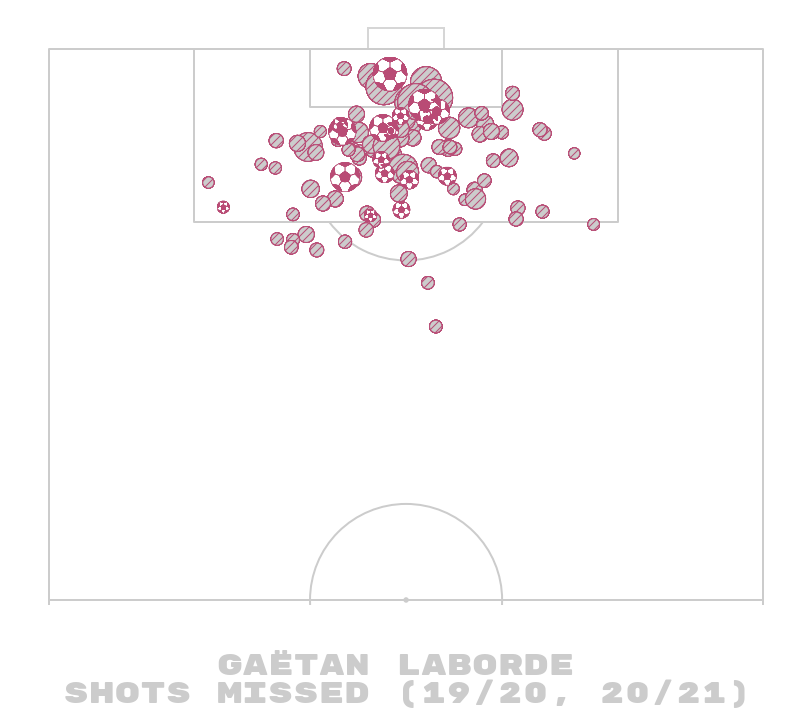

time: 788 ms (started: 2021-09-29 16:38:07 +02:00)


In [19]:
# Where are the shots coming from?

fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))

Team='Dinamo Zagreb'
Player='Gaëtan Laborde'
Type='Pass'
Technique='Through Ball'
Pattern='Regular Play'

# filter goals / non-shot goals
df_goals = LM[(LM.shot_outcome == 'Goal')].copy()
df_non_goal_shots = LM[(LM.shot_outcome != 'Goal')].copy()

pitch = VerticalPitch(pitch_type='uefa',pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch
sc1 = pitch.scatter(df_non_goal_shots.Start_x, df_non_goal_shots.Start_y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_non_goal_shots.shot_statsbomb_xg * 1900) + 100,
                    edgecolors='#b94b75',  # give the markers a charcoal border
                    c=pitch.line_color,  # no facecolor for the markers
                    hatch='///',  # the all important hatch (triple diagonal lines)
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',
                    ax=ax)

# plot non-goal shots with hatch
sc2 = pitch.scatter(df_goals.Start_x, df_goals.Start_y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_goals.shot_statsbomb_xg * 1900) + 100,
                    edgecolors='#b94b75',
                    linewidth=0.6,
                    c='white',
                    marker='football',
                    ax=ax)



txt = ax.text(x=35, y=45, s='Gaëtan Laborde\n Shots Missed (19/20, 20/21)',
              size=30,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              fontproperties=fm_rubik.prop, color=pitch.line_color,
              va='center', ha='center')


222


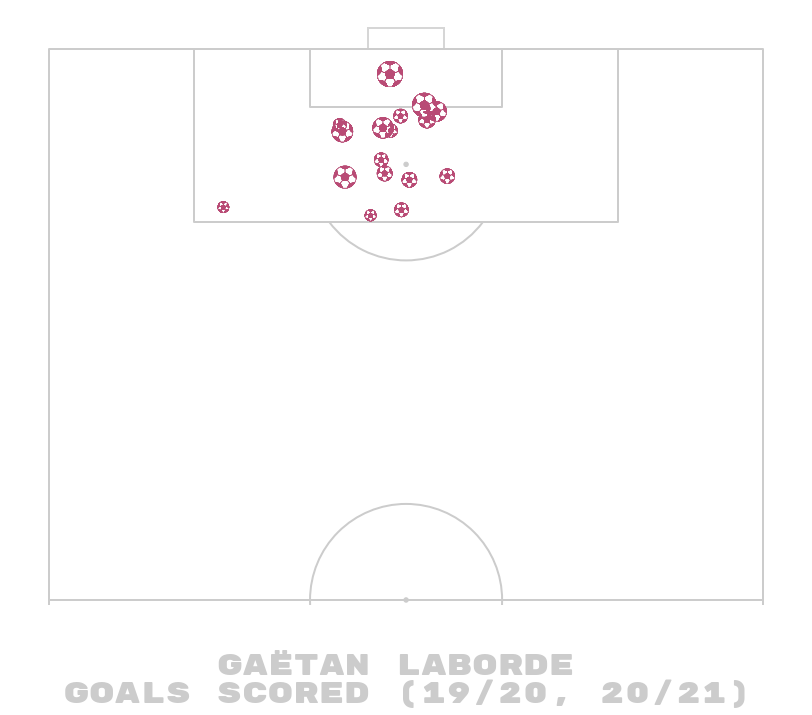

time: 1.08 s (started: 2021-09-29 16:39:48 +02:00)


In [20]:
# Where are the shots coming from?

fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))

# filter goals / non-shot goals
df_goals = LM[LM.shot_outcome == 'Goal'].copy()
print(len(df_goals))

pitch = VerticalPitch(pitch_type='uefa',pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch
sc1 = pitch.scatter(df_goals.Start_x, df_goals.Start_y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_goals.shot_statsbomb_xg * 1000) + 100,
                    edgecolors='#b94b75',
                    linewidth=0.6,
                    c='white',
                    marker='football',
                    ax=ax)

txt = ax.text(x=35, y=45, s='Gaëtan Laborde\n Goals Scored (19/20, 20/21)',
              size=30,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              fontproperties=fm_rubik.prop, color=pitch.line_color,
              va='center', ha='center')

In [51]:
check=LM1[(LM['shot_type'] == 'Open Play') & (LM['Shot_distance_ind'] == 'Outside-Box')][['Shot_distance','index','shot_outcome','Opp_players_Front_of_Shot']]
check

Shot_distance  index shot_outcome  Opp_players_Front_of_Shot
106       8.858909    115        Saved                          1
107       9.994815    116        Saved                          0
108      12.744433    117         Goal                          1
109      15.430768    118        Saved                          0
110       9.671373    119        Off T                          2
111       7.285376    120        Saved                          1
112      10.849786    124        Off T                          0

time: 9.13 ms (started: 2021-10-04 10:31:34 +02:00)


In [59]:
SHOT_ID = 28
df_freeze_frame = LM[(LM['index'] == SHOT_ID)].copy().reset_index(drop=True)

time: 2.02 ms (started: 2021-10-04 10:36:23 +02:00)


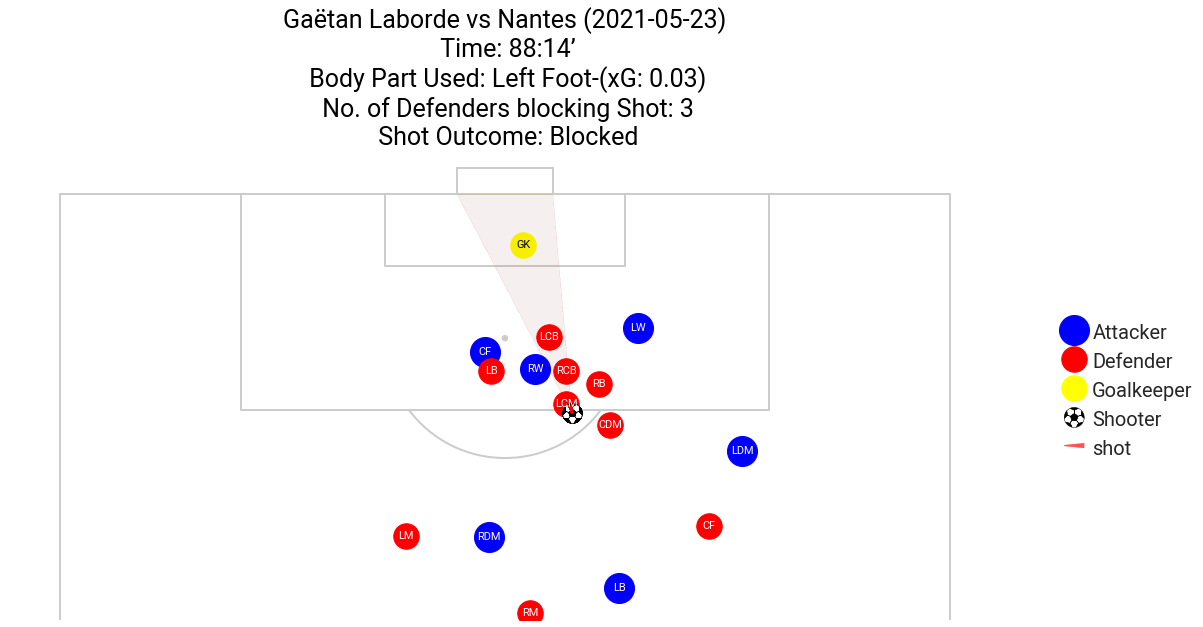

time: 1.48 s (started: 2021-10-04 16:10:40 +02:00)


In [65]:
# strings for team names
team1 = list(df_freeze_frame.Team.unique())
team1.remove('Opposition')
team1=team1[0]

team2 = list(set(df_freeze_frame.Opposition.unique()))[0]

SO=df_freeze_frame.Opp_players_Front_of_Shot[0]
SO1=df_freeze_frame.shot_outcome[0]
SO2=df_freeze_frame.shot_body_part[0]
SO3=df_freeze_frame.match_date[0]
SO4=df_freeze_frame.minute[0]
SO5=df_freeze_frame.second[0]

Goal_xG=round(df_freeze_frame.shot_statsbomb_xg.iloc[0],2)


# subset the team shooting, and the opposition (goalkeeper/ other)
df_team1 = df_freeze_frame[df_freeze_frame.Team == team1]
df_team2_goal = df_freeze_frame[(df_freeze_frame.Team == 'Opposition') &
                                (df_freeze_frame.Abb_Positions == 'GK')]
df_team2_other = df_freeze_frame[(df_freeze_frame.Team == 'Opposition') &
                                 (df_freeze_frame.Abb_Positions != 'GK')]


# Setup the pitch
pitch = VerticalPitch(pitch_type='uefa',half=True, goal_type='box', pad_bottom=-20)

# We will use mplsoccer's grid function to plot a pitch with a title axis.
fig, axs = pitch.grid(figheight=8, endnote_height=0,  # no endnote
                      title_height=0.1, title_space=0.02,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.83)

# Plot the players
sc1 = pitch.scatter(df_team1.x, df_team1.y, s=900, c='blue', label='Attacker', ax=axs['pitch'])
sc2 = pitch.scatter(df_team2_other.x, df_team2_other.y, s=650,
                    c='red', label='Defender', ax=axs['pitch'])
sc4 = pitch.scatter(df_team2_goal.x, df_team2_goal.y, s=650,
                    ax=axs['pitch'], c='yellow', label='Goalkeeper')

# plot the shot
sc3 = pitch.scatter(df_freeze_frame.Start_x, df_freeze_frame.Start_y, marker='football',
                    s=400, ax=axs['pitch'], label='Shooter', zorder=1.2)
line = pitch.lines(df_freeze_frame.Start_x, df_freeze_frame.Start_y,
                   df_freeze_frame.End_x, df_freeze_frame.End_y, comet=True,
                   label='shot', color='red', ax=axs['pitch'])

# plot the angle to the goal
pitch.goal_angle(df_freeze_frame.Start_x, df_freeze_frame.Start_y, ax=axs['pitch'], alpha=0.005, zorder=1.1,
                 color='#F6C244', goal='right')

# fontmanager for google font (robotto)
robotto_regular = FontManager()

# plot the jersey numbers
for i, label in enumerate(df_freeze_frame.Abb_Positions):
    
    if label=='GK':
        
        pitch.annotate(label, (df_freeze_frame.x[i], df_freeze_frame.y[i]),
                   va='center', ha='center', color='black',weight='bold',
                   fontproperties=robotto_regular.prop, fontsize=11, ax=axs['pitch'])
        
    else:
        
        pitch.annotate(label, (df_freeze_frame.x[i], df_freeze_frame.y[i]),
           va='center', ha='center', color='white',weight='bold',
           fontproperties=robotto_regular.prop, fontsize=11, ax=axs['pitch'])
        
        

# add a legend and title
legend = axs['pitch'].legend(labelspacing=1,bbox_to_anchor=(1.2, 0.65))
for text in legend.get_texts():
    text.set_fontproperties(robotto_regular.prop)
    text.set_fontsize(20)
    text.set_va('center')

Shooter=Player   
# title
axs['title'].text(0.5, 0.9, f'{Shooter} vs {team2} ({SO3})\n Time: {SO4}:{SO5}’\n Body Part Used: {SO2}-(xG: {Goal_xG})\n No. of Defenders blocking Shot: {SO}\n Shot Outcome: {SO1}',
                  va='center', ha='center', color='black',
                  fontproperties=robotto_regular.prop, fontsize=25)
plt.show()  # If you are using a Jupyter notebook you do not need this line

In [177]:
h_df=df[df['match_id']==3758271].reset_index(drop=True)
h_df.to_excel('/Users/vignesh.jayanth/Documents/h_df.xlsx')


time: 2.5 s (started: 2021-10-01 16:16:04 +02:00)


In [11]:
Comps=pd.DataFrame(sb.competitions(fmt="dict",creds=credentials)).T.reset_index(drop=True)

Comps.to_excel('/Users/vignesh.jayanth/Documents/Comps.xlsx')


time: 181 ms (started: 2021-10-04 09:54:44 +02:00)
